In [1]:
import sys

import gym
import numpy as np
import scipy.integrate as sc_integrate

import ray
from ray.rllib.algorithms.ppo import PPO
from ray.tune.logger import pretty_print

import symbtools as st
import sympy as sp
import pickle
import matplotlib.pyplot as plt

## Mathematical system description with SymPy / symbtools

In [2]:
# load model etc. from pickle of flatness analysis notebook
with open("single_crane_model.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [3]:
mod.xx

Matrix([
[   p1],
[   p2],
[   q1],
[pdot1],
[pdot2],
[qdot1]])

In [4]:
mod.calc_state_eq(force_recalculation=True)
mod.eqns

Matrix([
[       m2*pddot1 - tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)],
[       g*m2 + m2*pddot2 - p2*tau2/sqrt(p2**2 + (p1 - q1)**2)],
[m1*qddot1 - tau1 + tau2*(p1 - q1)/sqrt(p2**2 + (p1 - q1)**2)]])

## Gym environment

In [5]:
from abc import abstractmethod
import inspect
import math
from typing import Optional, Union

import numpy as np
from scipy.integrate import solve_ivp

import gym
from gym import logger, spaces
#from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled
#from gym.utils.renderer import Renderer

class StateSpaceModel(gym.Env):
    """ Environment subclass that uses a state space model of the form dx/dt = f(x, u)
    to represent the environments dynamics.

    Args:
        ode
        cost
        x0
        uDim

    Attributes:
        ode (function): ODE for simulation
        cost (function): cost function (returns scalar)
        o
        o_
        oDim
    """

    def __init__(self, ode, cost, x0, uDim, dt,
                 terminal_cost=-1e4):
        self.tt = [0]
        self.dt = dt
        if callable(x0):
            self.x0 = x0  # initial state
            x0 = x0()
        else:
            x0 = list(x0)
            self.x0 = x0
        self.x = x0  # current state
        self.x_ = x0 # previous state x[k-1]
        self.xDim = len(x0) # state dimension
        self.uDim = uDim # inputs
        self.o = self.x
        self.o_ = self.x_
        self.oDim = len(self.o)  # observation dimensions
        self.ode = ode
        params = inspect.signature(cost).parameters
        cost_args = params.__len__()
        if cost_args == 1:
            self.cost = lambda x_, u_, x, t, mod: cost(x_)
        elif cost_args == 2:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_)
        elif cost_args == 3:
            if 'mod' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, mod)
            elif 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x)
        elif cost_args == 4:
            if 'mod' in params and 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, t, mod)
            elif 'mod' in params and not 't' in params:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, mod)
            else:
                self.cost = lambda x_, u_, x, t, mod: cost(x_, u_, x, t)
        elif cost_args == 5:
            self.cost = cost
        else:
            print('Cost function must to be of the form c(x_, u_, x, t, mod), where mod is numpy/sympy.')
            assert(True)
            
        self.terminated = False
        self.terminal_cost = terminal_cost
    
    def get_state(self):
        return self.x

    def reset(self):
        """ Resets environment to state x0

        Args:
            x0 (array, list, callable): initial state

        """
        if callable(self.x0):
            x0 = self.x0()
        self.x_ = x0
        self.x = x0
        self.tt = [0]
        self.terminated = False
        return np.array(self.x, dtype=np.float32)

    def step(self, *args):
        """ Simulates the environment for 1 step of time t.

        Args:
            dt (int, float): duration of step (not solver step size)
            u (array): control/action

        Returns:
            c (float): cost of state transition

        """
        self.x_ = self.x  # shift state (x[k-1] = x[k])
        self.o_ = self.o
        if args.__len__()==2:
            u = args[0]
            dt = args[1]
        elif args.__len__() == 1:
            u = args[0]
            dt = self.dt

        # system simulation
        sol = solve_ivp(lambda t, x: self.ode(t, x, u, self.dxdt), (0, dt), self.x_, 'RK45')
        # todo: only output value of the last timestep
        y = list(sol.y[:, -1])  # extract simulation result
        self.x = y
        self.tt.extend([self.tt[-1] + dt])  # increment simulation time
        self.terminated = self.terminate(self.x)
        #x_2pi = mapAngles(self.xIsAngle, self.x_)
        #x2pi = mapAngles(self.xIsAngle, self.x)
        #c = (self.cost(x_2pi, u, x2pi, np) + self.terminal_cost*self.terminated)*dt
        t = self.tt[-1]
        c = (self.cost(self.x_, u, self.x, t, np) + self.terminal_cost * self.terminated) * dt
        
        # todo: place difference for desired value with function or smth here
        self.o =  np.array(self.x, dtype=np.float32)
        reward = c
        return self.o, reward, self.terminated, {"info": False}
    
    @abstractmethod
    def terminate(self, *args):
        return



class CartPoleEnv(StateSpaceModel):

    metadata = {}

    def __init__(self, cost, x0, dt, mod):
        super(CartPoleEnv, self).__init__(self.ode, cost, x0, 2, dt)
        
        self.spec = gym.envs.registration.EnvSpec(id='CartPoleEnv-v0', max_episode_steps=1000)
        
        F1, F2 = sp.symbols('F1 F2')

        params = sp.symbols('m1, m2, l1, g')
        st.make_global(params)
        params_values = [(m1, 1.0), (m2, 0.1), (l1, 0.5), (g, 9.81)]
        
        states_dot = mod.f + mod.g * sp.Matrix([F1, F2]) ##:
        states_dot_wo_params = states_dot.subs(params_values)
        self.dxdt = st.expr_to_func([*mod.xx, F1, F2], states_dot_wo_params)

        # define observation space
        high_obs = np.array(
            [
                100.0,
                100.0,
                100.0,
                100.0,
                100.0,
                100.0
            ],
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high_obs, high_obs, dtype=np.float32)
        
        # define action space
        high_act = np.array(
            [ 
                2.0,
                2.0
            ],
            dtype=np.float32,
        )
        self.action_space = spaces.Box(-high_act, high_act, dtype=np.float32)
    
    def ode(self, t, x, u, dxdt):
        u1, u2 = u
        states_dot = dxdt(*x, u1, u2 - 0.981)
        return np.array(states_dot, dtype=np.float32)
    
    def terminate(self, x):
        x1, x2, x3, x4, x5, x6 = x
        if abs(x3) > 50 or abs(x2+0.3) > 0.3 or abs(x1) > 50:
            return True
        else:
            return False

## Cost function, Initial values

In [6]:
mod.xx.T

Matrix([[p1, p2, q1, pdot1, pdot2, qdot1]])

In [22]:
# define the incremental cost
def c_k(x, u):
    x1, x2, x3, x4, x5, x6 = x
    u1, u2 = u
    
    
    c = -10*(x2+0.3)**2 - 10*(x3-1)**2 #+ 0.01*u1**2 - 0.1*x5**2 - 0.1*x6**2
    
    if abs(x2+0.3) < 0.02:
        c = c + 1
    if abs(x3-1) < 0.05:
        c = c + 1

    return c

# define the function, that represents the initial value distribution p(x_0)
def p_x0():
    x0 = [
            np.random.uniform(-0.001,0.001), 
            -0.5 + np.random.uniform(-0.001,0.001), 
            np.random.uniform(-0.001,0.001), 
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001),
            np.random.uniform(-0.001,0.001)
    ]
    return x0

t = 10 # time of an episode
dt = 0.01 # time step-size

learning_iterations = int(100) # define training iterations

## Create Gym env

In [23]:
# environment without renderings for training
env = CartPoleEnv(c_k, p_x0, dt, mod)

In [24]:
env.reset()
env.step(env.action_space.sample())
env.observation_space

Box([-100. -100. -100. -100. -100. -100.], [100. 100. 100. 100. 100. 100.], (6,), float32)

## Configure RL algo

In [10]:
ray.init()

2022-09-22 09:09:50,464	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.10.4
Ray version:,2.0.0


In [25]:
from ray.tune.registry import register_env

def env_creator(env_config):
    return CartPoleEnv(**env_config) # return an env instanceregister_env("my_env", env_creator)

In [26]:
register_env("CartPoleCustom", env_creator)

In [27]:
'''import ray
import ray.rllib.algorithms.ppo as ppo
from ray.tune.logger import pretty_print

config = ppo.DEFAULT_CONFIG.copy()
config["num_gpus"] = 0
config["num_workers"] = 1
algo = ppo.PPO(config=config, env="CartPole-v0")
'''

'import ray\nimport ray.rllib.algorithms.ppo as ppo\nfrom ray.tune.logger import pretty_print\n\nconfig = ppo.DEFAULT_CONFIG.copy()\nconfig["num_gpus"] = 0\nconfig["num_workers"] = 1\nalgo = ppo.PPO(config=config, env="CartPole-v0")\n'

In [28]:
#config

In [29]:
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "CartPoleCustom",
    "env_config": {"cost":c_k, "x0":p_x0, "dt":dt, "mod":mod},
    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 30,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "model": {
        "fcnet_hiddens": [128, 128],
        "fcnet_activation": "relu",
    },
    # Set up a separate evaluation worker set for the
    # `algo.evaluate()` call after training (see below).
    "evaluation_num_workers": 1,
    # Only for evaluation runs, render the env.
    "evaluation_config": {
        "render_env": False,
    },
}


## Training the model

In [30]:
agent = PPO(config=config)

2022-09-22 09:18:38,383	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-09-22 09:18:38,384	WARNING ppo.py:350 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=30 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 134.


(RolloutWorker pid=6740) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6738) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6744) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6756) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6760) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6731) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6730) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6739) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6734) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6732) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6746) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6736) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6737) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6749) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6750) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6747) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6742) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6753) ]0;IPython: cluster/kwrede
(RolloutWorker pid=6751) ]0

2022-09-22 09:18:48,424	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-09-22 09:18:48,426	WARNING algorithm.py:2099 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-09-22 09:18:48,427	WARNING ppo.py:350 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=30 num_envs_per_worker=1 rollout_fragment_length=134)! Auto-adjusting `rollout_fragment_length` to 134.


(RolloutWorker pid=7728) ]0;IPython: cluster/kwrede


2022-09-22 09:18:53,244	INFO trainable.py:160 -- Trainable.setup took 14.875 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-22 09:18:53,246	WARNING util.py:65 -- Install gputil for GPU system monitoring.


In [31]:
for _ in range(learning_iterations):
    result = agent.train()

In [32]:
agent.evaluate()

{'evaluation': {'episode_reward_max': 11.17313443184994,
  'episode_reward_min': 8.915874825615305,
  'episode_reward_mean': 10.520964132788981,
  'episode_len_mean': 1000.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [10.604559332063134,
    10.572437709508419,
    10.279262291241421,
    10.964081733137586,
    10.619429055607926,
    8.915874825615305,
    10.779853310666082,
    10.771328179367021,
    11.17313443184994,
    10.529680458832988],
   'episode_lengths': [1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.2058226279575411,
   'mean_inference_ms': 0.6640153626849229,
   'mean_action_processing_ms': 0.09741981963302693,
   'mean_env_wait_ms': 0.8964955049828879,
   'mean_env_render_ms': 0.0},
  'num_faulty_episodes': 0,
  'num_a

## Testing the model

In [49]:
u1_for_plots = []
u2_for_plots = []
x1_for_plots = []
x2_for_plots = []
x3_for_plots = []

obs = env.reset()
for i in range(1000):
    # inference smoothing!
    act_mean = [0, 0]
    for i in range(0, 4):
        action = agent.compute_action(obs)
        act_mean = act_mean + action
    action = act_mean/4
    obs, reward, done, info = env.step(action)
    u1_for_plots = np.append(u1_for_plots, action[0])
    u2_for_plots = np.append(u2_for_plots, action[1])
    x1_for_plots = np.append(x1_for_plots, obs[0])
    x2_for_plots = np.append(x2_for_plots, obs[1])
    x3_for_plots = np.append(x3_for_plots, obs[2])
    if done:
      obs = env.reset()
      break;

## Plotting

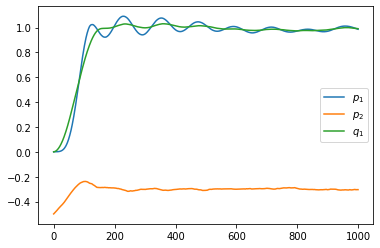

In [50]:
plt.plot(x1_for_plots, label=r"$p_1$")
plt.plot(x2_for_plots, label=r"$p_2$")
plt.plot(x3_for_plots, label=r"$q_1$")
plt.legend()

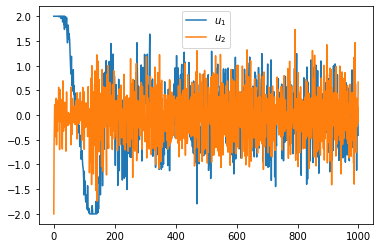

In [51]:
plt.plot(u1_for_plots, label=r"$u_1$")
plt.plot(u2_for_plots, label=r"$u_2$")
plt.legend()